In [ ]:
!pip install pytorch-forecasting


In [22]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.preprocessing import StandardScaler
from pytorch_forecasting.data.encoders import (
    EncoderNormalizer,
    GroupNormalizer,
    MultiNormalizer,
    NaNLabelEncoder,
    TorchNormalizer,
)
from torchmetrics import MeanAbsolutePercentageError


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths

In [5]:
df=pd.read_excel('full_gefira_hourly.xlsx')

In [6]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Daste' as the index
df.set_index('Date', inplace=True)

In [7]:
# Convert columns to numeric
numeric_columns = ['Water Level','Streamflow','Precipitation','Tmean','Tmin','Tmax','SolRad','Pmean','windSp']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [8]:
from scipy.interpolate import CubicSpline
# Step 1: Drop rows with NAs for interpolation
df_interp = df.dropna()

# Step 2: Create a cubic spline interpolation function for each column
for column in df.columns:
    if df[column].isna().sum() > 0:
        cs = CubicSpline(df_interp.index, df_interp[column], bc_type='natural')
        df[column] = cs(df.index)
print('Successfully added missing values with spline interpolation')

Successfully added missing values with spline interpolation


In [9]:
date = df.index
df['Hour'] = date.hour
df['WeekDay'] = date.dayofweek
df['Month'] = date.month

In [11]:
print("NaN values in dataframe ")
print( df.isna().sum())
# Create a boolean mask for NaN values
nan_mask = df.isna()

# Get the indices where NaN values are present
nan_indices = df.index[nan_mask.any(axis=1)].tolist()

print("Indices with NaN values:", nan_indices)

NaN values in dataframe 
Water Level      0
Streamflow       0
Tmean            0
Tmin             0
Tmax             0
SolRad           0
Pmean            0
Precipitation    0
windSp           0
Hour             0
WeekDay          0
Month            0
dtype: int64
Indices with NaN values: []


In [12]:
# Generate a complete date range from the minimum to maximum date in the DataFrame
complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

# Find the missing dates by subtracting the existing dates from the complete date range
missing_dates = complete_date_range.difference(df.index)

# Print or display the missing dates
print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex([], dtype='datetime64[ns]', freq='H')


In [10]:
df.head()

,Water Level,Streamflow,Tmean,Tmin,Tmax,SolRad,Pmean,Precipitation,windSp,Hour,WeekDay,Month
Date,,,,,,,,,,,,
2017-07-04 14:00:00,41.0,1520.20,13.583333,13.0,14.0,0.0,0.0,0.0,0.0,14,1,7
2017-07-04 15:00:00,41.0,1520.20,13.850000,13.5,14.7,0.0,0.0,0.0,0.0,15,1,7
2017-07-04 16:00:00,41.0,1520.20,14.150000,13.9,14.4,1.7,0.0,0.0,0.0,16,1,7
2017-07-04 17:00:00,40.0,1448.66,14.250000,14.2,14.3,0.0,0.0,0.0,0.0,17,1,7
2017-07-04 18:00:00,42.0,1593.42,14.266667,14.1,14.4,0.0,0.0,0.0,0.0,18,1,7


In [17]:
# Define features, target, and training cutoff
features=['Precipitation', 'Tmean','Tmin','Tmax','SolRad','windSp']
features.append('time_idx')
scalers = {feature: EncoderNormalizer() for feature in features}
target = 'Streamflow'

In [13]:
training_split =pd.to_datetime("2020-04-11")  # day for cutoff
data=df[df.index <= training_split] # training data
data2=df[df.index > training_split ] # testing data

In [14]:
#Defining time index as +1 increment for each hour
data['time_idx'] = np.arange(len(data))
data["time_idx"] = data["time_idx"].astype(int)
data2['time_idx'] = np.arange(len(data2))
data2["time_idx"] = data2["time_idx"].astype(int)

In [15]:
# Group column indicates a time series.
# In our case it's all 0's.
data['group']=[0 for i in range(len(data))]
data2['group']=[0 for i in range(len(data2))]

# Temporal Fusion Transformer
The TFT model will be used similarly to [(Koyan & Roy 2023)](https://doi.org/10.48550/arXiv.2305.12335)
The following code uses the TimeSeriesDataSet() class from pytorch forecasting. Key variables are encoder/decoder sizes which need to be determined.

In [18]:
min_prediction_length = 1
min_encoder_length=12*30
max_prediction_length = 24
max_encoder_length = 39*24

target_lags=[12,24,48,72,360,480,1200]
groups=['group']

training_cutoff = data["time_idx"].max() - max_prediction_length

# Define the dataset
training = TimeSeriesDataSet(
    data=data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='Streamflow',
    group_ids=groups,  # replace with your actual group IDs if you have multiple series
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=min_encoder_length,
    min_prediction_length=min_prediction_length,
    min_prediction_idx=0,
    time_varying_known_reals=["time_idx","Hour"]+features,
    static_reals=[],
    static_categoricals=[],
    time_varying_unknown_reals=['Streamflow'],
    time_varying_unknown_categoricals=[],
    target_normalizer=EncoderNormalizer(),  # normalizes the target variable
    scalers=scalers, # adds specified scalers to data
    lags={'Streamflow': target_lags}, # adds target lags.
    add_relative_time_idx=True,
    add_target_scales=True,
    allow_missing_timesteps=False, # Set to True if your data has missing timesteps
    predict_mode=True,
    add_encoder_length=True
)
print('Timeseries dataset done')

validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
print('Validation dataset done')

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=7)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=7)

print("Ready to train...")

Timeseries dataset done
Validation dataset done
Ready to train...


In [24]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.0457,
    # limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    lstm_layers=3, # 2 maybe optimal
    learning_rate=0.0019498445997580445, # determined by next code cell
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 161.5k


In [ ]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")


In [27]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: 
   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 640   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 37.2 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 32.2 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [29]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

Model Evaluation

In [30]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
# this model is useful for comparing
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(135.9754)

In [31]:
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
MAE()(predictions.output, predictions.y)

tensor(163.5988)

In [35]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

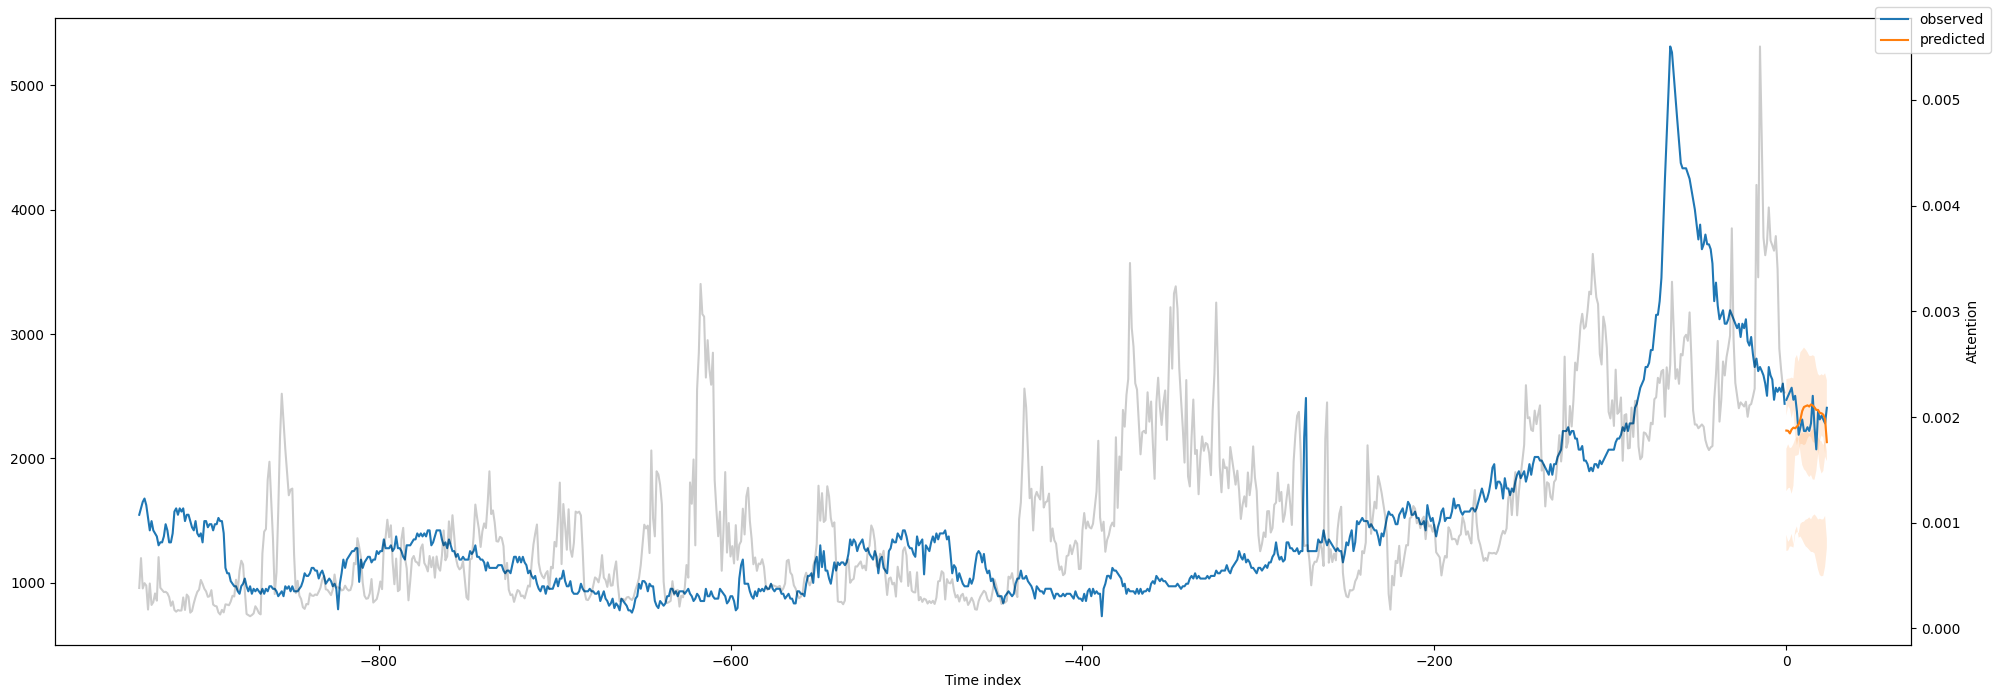

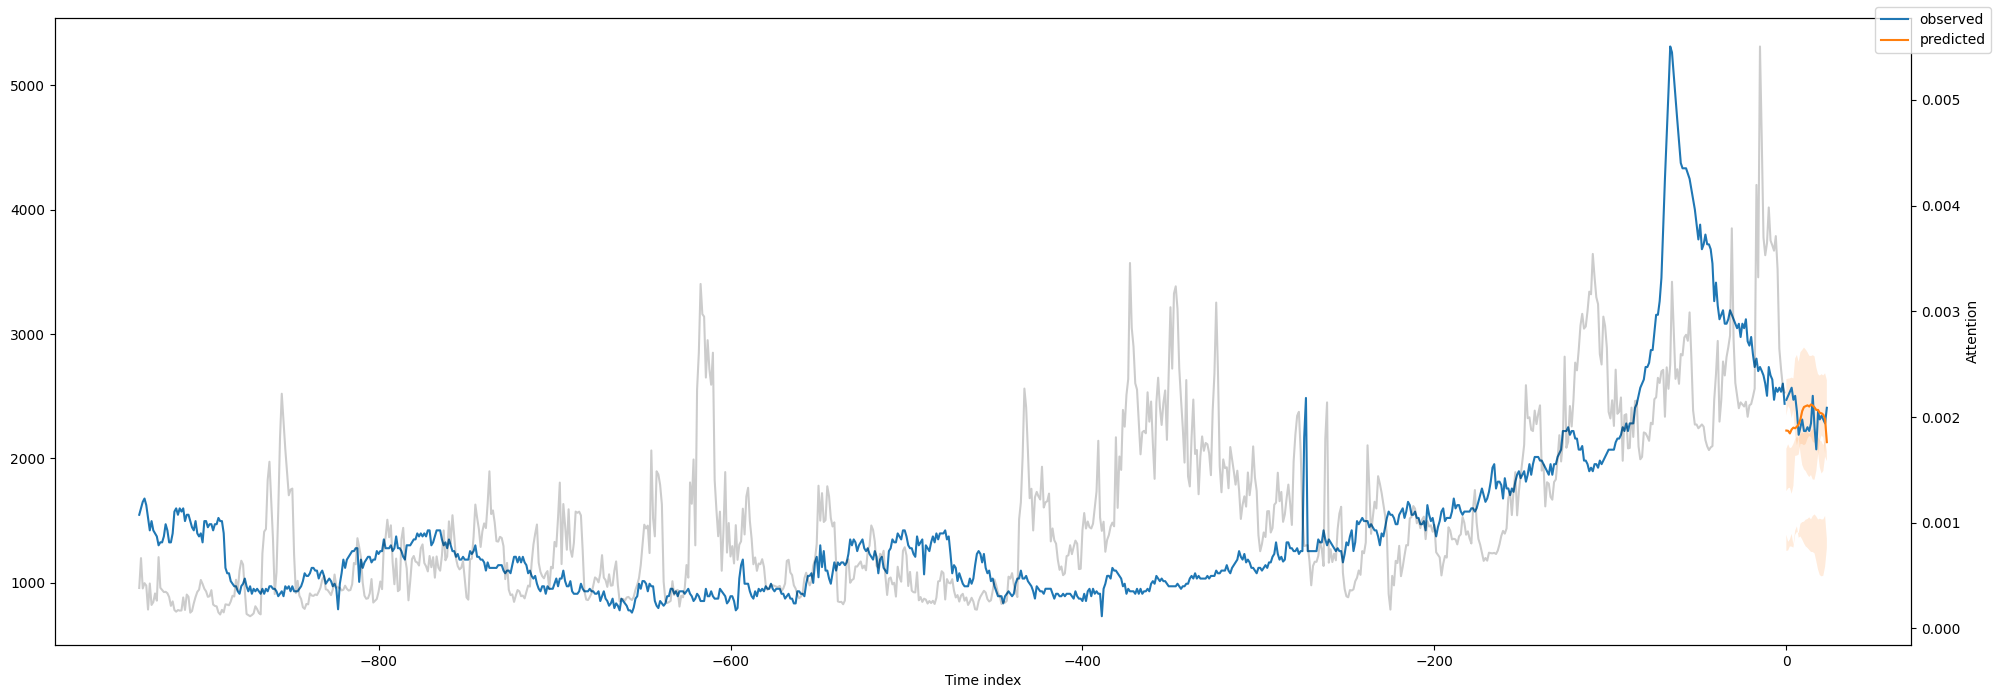

In [36]:
fig, ax = plt.subplots(figsize=(20, 7))
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, ax=ax)

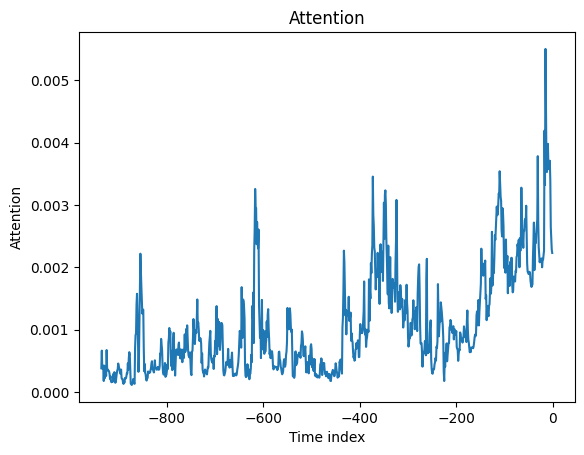

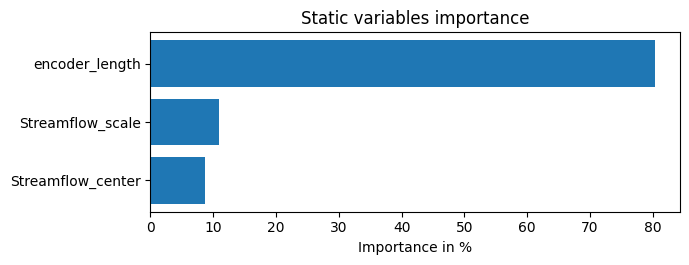

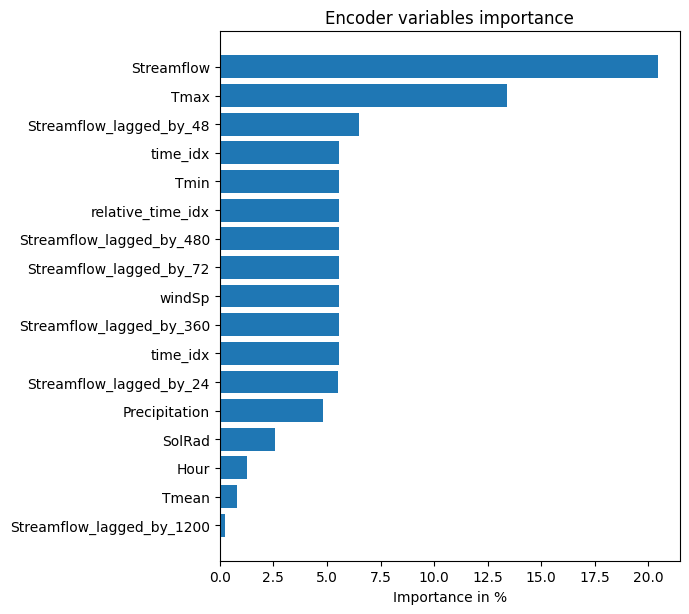

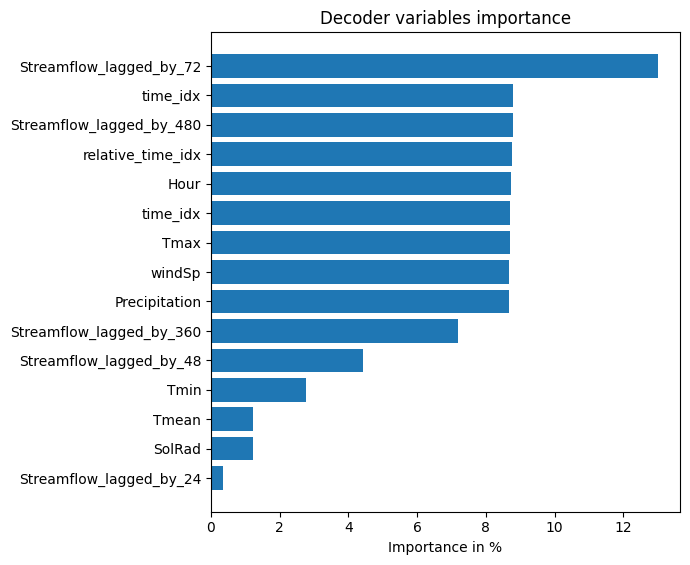

In [37]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation);

Hyperparameter tuning

In [ ]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=20,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)
import pickle
# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-12-03 17:40:11,961] A new study created in memory with name: no-name-76325b0e-2ec7-48a0-8214-6b5154252b9b
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-12-03 17:43:08,529] Trial 0 finished with value: 655.9119262695312 and parameters: {'gradient_clip_val': 0.8116875481704078, 'hidden_size': 17, 'dropout': 0.18912095715122829, 'hidden_continuous_size': 15, 'attention_head_size': 4, 'learning_rate': 0.001493960492566289}. Best is trial 0 with value: 655.9119262695312.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 